<a href="https://colab.research.google.com/github/MFarooq-02/QLBS-RL/blob/main/QLBS_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install psx-data-reader
%pip install scipy
%pip install bspline
from psx import stocks, tickers
import datetime
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import scipy
from scipy.stats import norm
import random
import bspline
import bspline.splinelab as splinelab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bspline: filename=bspline-0.1.1-py3-none-any.whl size=84481 sha256=c131e0e6c251f910af0d8a965f40a8da367e28bff47725ada4c049546247fba9
  Stored in directory: /root/.cache/pip/wheels/3c/ab/0a/70927853a6d9166bc777922736063a6f99c43a327c802f9326
Successfully built bspline


In [ ]:
S0 =  234.23      # initial stock price
K =    63.65  #strike price
r =    0.098  # risk-free rate 10-yr yield on Pib bon
mu =   0.056    # drift
sigma = 0.71  # volatility
M = 1         # maturity
T = 4        # number of time steps
risk_lambda = 0.001      # risk aversion
reg_param = 1e-3  #regulatory parameter
eta = 0.05 #noise generated, it can be 0.005,0.5,0.05
hyper_param =  1e-1
N_MC = 10000  # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

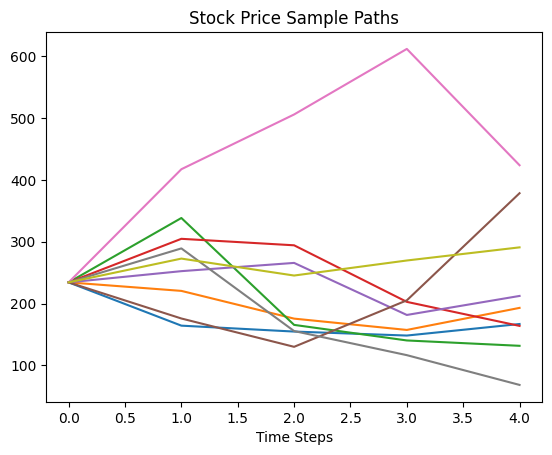

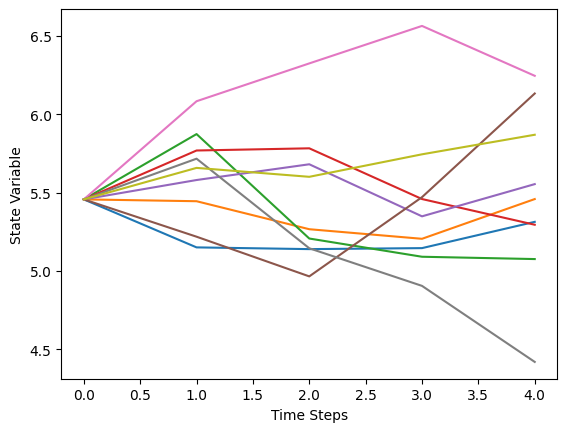

            0           1           2            3            4
1      234.23  266.034118  241.176308   289.005340   472.533321
2      234.23  205.237243  179.834228   299.958317   375.054125
3      234.23  188.788555  217.940905   176.037698   142.074505
4      234.23  243.030669  117.326501    60.558045    47.227566
5      234.23  155.669628  165.716963   114.310708    65.926464
...       ...         ...         ...          ...          ...
9996   234.23  168.448738  191.043409   177.833979   155.426958
9997   234.23  165.409422   89.118955   151.434627   130.144217
9998   234.23  583.775129  731.315012  1333.038972  1806.040285
9999   234.23  235.936871  181.704791   122.314142   173.305561
10000  234.23  245.029381  290.389608   369.223569   398.919941

[10000 rows x 5 columns]


In [ ]:
# make a dataset

np.random.seed(42) # Fix random seed
# stock price
S = pd.DataFrame(np.zeros((N_MC,T+1)), index=range(1, N_MC+1), columns=range(T+1))  # make a data frame for values of S(stock price)
S.loc[:,0] = S0 # denote the first value of the dataframe S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1)) #generate standard normal random numbers in normal distribution

for t in range(1, T+1):
    #codify the equation for s in interval 0<s<t, Z(normal distribution) are the standard normal random numbers generated in RN
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

#codify the eq for delta S and delta S hat
delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable is given as
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

# plot 10 paths for both S(stock price) and X(state variable)
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()
print(S.iloc[:,:])

In [ ]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(ST-K, 0)
    return payoff
print(terminal_payoff(S0,K))

170.57999999999998


X.shape =  (10000, 5)
X_min, X_max =  2.5523438772457077 7.919709685706471
Number of points k =  17


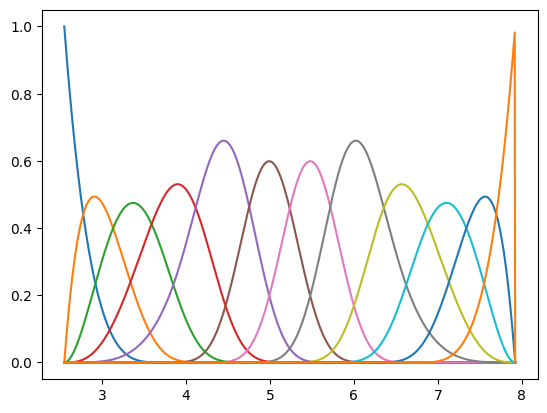

<Figure size 640x480 with 0 Axes>

In [ ]:
# Build intervals for nodes from min to max nodes
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

#This corresponds to higher-order interpolation, where the curve is a sequence of polynomial segments of degree 4 or more.
#This can produce very smooth and accurate curves, but it also requires more computation and more control points.
#It may also suffer from overfitting, oscillations, or ill-conditioning, especially for high degrees to counter that we use regulatory parameters.
p = 4         #degree of B-spline
#Number of collocation points, these points should be >=p+1,these points play a crucial role in approximating the function using B-spline basis functions.
ncolloc = 12
#create an array of ncolloc evenly spaced numbers between X_min and X_max. This array is the set of breakpoints for the B-spline basis functions.
tau = np.linspace(X_min,X_max,ncolloc)
#create an array of knots for the B-spline basis functions, based on the breakpoints tau and the degree p.
k = splinelab.aptknt(tau, p)
basis = bspline.Bspline(k, p) # represents the B-spline basis functions, based on the knots k and the degree p.
f = plt.figure()
print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [ ]:
num_t_steps = T + 1
num_basis =  ncolloc # len(k)
#create an empty 3D array for basis function, where N_MC represents rows, num_basis represents columns and this 2D array is stacked upon by num_t_steps
data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)


for i in np.arange(num_t_steps):
    x = X.values[:,i]
    #Fills the data_mat_t tensor with values computed using a basis function (denoted by basis(el)).
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

num_basis =  12
dim data_mat_t =  (5, 10000, 12)


In [ ]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)

In [ ]:
print(data_mat_t.shape)  # shape num_steps x N_MC x num_basis
print(len(k))

(5, 10000, 12)
17


In [ ]:
# functions to compute optimal hedges
def function_A_vec(t, delta_S_hat, data_mat, reg_param): #we define the function for A matrix

    X_mat = data_mat[t, :, :] # make a state variable matrix of dimension N_MC x num_basis
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).values.reshape(-1,1) #calculate square of delta S hat
    # A regularization parameter is defined to prevent overfitting
    #np.eye creates a diagonal matrix
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs) #codify the A matrix function with defined parameters

    return A_mat

def function_B_vec(t,
                   Pi_hat,
                   delta_S_hat=delta_S_hat,
                   S=S,
                   data_mat=data_mat_t,
                   gamma=gamma,
                   risk_lambda=risk_lambda): #we define the function for B vector

    # coef = 1/(2 * gamma * risk_lambda)
    # override it by zero to have pure risk hedge
    coef = 0 # keep it

    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]+(coef* delta_S.loc[:,t]) # calculate the first term in the bracket in equation
    X_mat = data_mat[t, :, :]  # make a state variable matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp) #codify the B Vector function with defined parameters

    return B_vec

In [ ]:
np.random.seed(42)

#calculte A Matrix by putting calculated data in the parameters of the function we created above

A_mat = function_A_vec(T-1, delta_S_hat, data_mat_t, reg_param)
idx_row = np.random.randint(low=0, high=A_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=A_mat.shape[1], size=50)


A_mat[idx_row, idx_col]

array([8.33214551e+06, 3.24993189e+04, 7.74328819e+05, 2.14718874e+07,
       5.62960243e+05, 8.33214551e+06, 4.15085121e+06, 1.25466968e+03,
       8.33214551e+06, 7.74328819e+05, 7.74328819e+05, 2.14718874e+07,
       5.62960243e+05, 3.24993189e+04, 2.14718874e+07, 2.14718874e+07,
       1.25466968e+03, 2.71298033e+06, 5.62960243e+05, 1.02219639e+02,
       2.14718874e+07, 8.04569976e+04, 2.71298033e+06, 1.02219639e+02,
       8.04569976e+04, 5.62960243e+05, 1.44925349e+01, 8.04569976e+04,
       4.15085121e+06, 2.71298033e+06, 8.04569976e+04, 1.25333525e+07,
       1.44925349e+01, 7.74328819e+05, 7.74328819e+05, 4.15085121e+06,
       8.04569976e+04, 8.04569976e+04, 1.25466968e+03, 8.04569976e+04,
       8.33214551e+06, 3.24993189e+04, 1.25333525e+07, 1.25466968e+03,
       5.62960243e+05, 1.25466968e+03, 8.33214551e+06, 5.62960243e+05,
       1.25333525e+07, 8.33214551e+06])

In [ ]:
np.random.seed(42)
#calculte B vector by putting calculated data in the parameters of the function we created above
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # defined a dataframe to store values for Pi
Pi.iloc[:,-1] = S.iloc[:,-1]-K #calculate hedge portfolio at terminal condition
Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # defined a dataframe to store values for Pi hat
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1]) #calculate pi hat
B_vec = function_B_vec(T-1, Pi_hat, delta_S_hat, S, data_mat_t, gamma, risk_lambda)

print(B_vec)
print("Pi",Pi)
print("S",S.iloc[:,-1])
print("pi hat",Pi_hat)
print(terminal_payoff(S0,K))

[-588.4691983114794 -2099.283358918462 -3358.1845189625465
 75592.05544030164 1491210.1583842407 7206059.7083972115
 19905285.976952974 43133482.48599332 31495662.72892022 12935751.614986649
 1470230.9984258157 -391746.6953519171]
Pi          0    1    2    3            4
1      NaN  NaN  NaN  NaN   408.883321
2      NaN  NaN  NaN  NaN   311.404125
3      NaN  NaN  NaN  NaN    78.424505
4      NaN  NaN  NaN  NaN   -16.422434
5      NaN  NaN  NaN  NaN     2.276464
...    ...  ...  ...  ...          ...
9996   NaN  NaN  NaN  NaN    91.776958
9997   NaN  NaN  NaN  NaN    66.494217
9998   NaN  NaN  NaN  NaN  1742.390285
9999   NaN  NaN  NaN  NaN   109.655561
10000  NaN  NaN  NaN  NaN   335.269941

[10000 rows x 5 columns]
S 1         472.533321
2         375.054125
3         142.074505
4          47.227566
5          65.926464
            ...     
9996      155.426958
9997      130.144217
9998     1806.040285
9999      173.305561
10000     398.919941
Name: 4, Length: 10000, dtype: float64


In [ ]:
# portfolio value
# explained above
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1]-K

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# optimal hedge
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) # make a data frame for optimal action a*
a.iloc[:,-1] = 0


for t in range(T-1, -1, -1):
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t,gamma, risk_lambda)

    phi = np.dot(np.linalg.inv(A_mat), B_vec) #calculating phi at t by multiplying inverse of A matrix with vector B

    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi) #the optimal action for the hedge portfolio
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t]) # the hedged portfolio created by optimal action
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')
print(np.mean(a.loc[:,0]))

0.9753384758752011


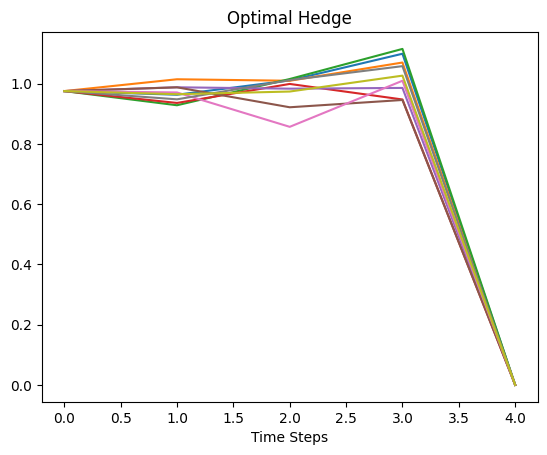

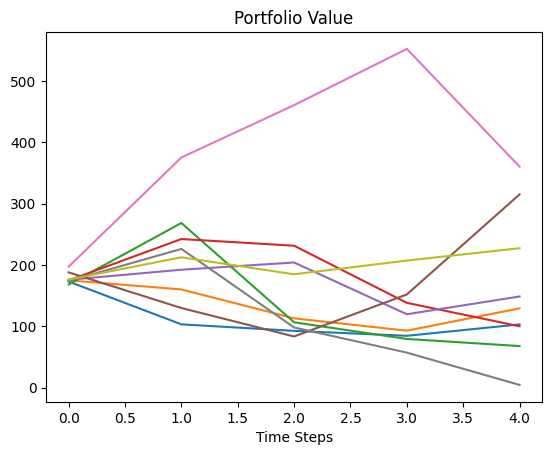

In [ ]:
#Visualising the optimal action and hedge portfolio
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()


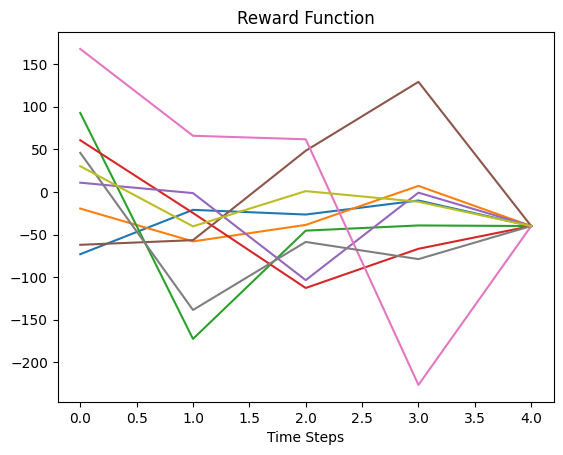

In [ ]:
# Compute rewards for all paths
# reward function
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) #create a dataframe for reward
R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1]) #reward at terminal condition

for t in range(T):
    R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t]) #calculate reward by codifying the given equation
# plot 10 paths for reward
plt.plot(R.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Reward Function')
plt.show()

In [ ]:
#Define C vec and D vec to calculate optimal Q function
def function_C_vec(t, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

def function_D_vec(t, Q, R, data_mat, gamma=gamma):
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    return D_vec

In [ ]:
# calculate C vec by putting in calculated data in the function created above
C_mat = function_C_vec(T-1, data_mat_t, reg_param)
np.random.seed(42)
idx_row = np.random.randint(low=0, high=C_mat.shape[0], size=50)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=C_mat.shape[1], size=50)

C_mat[idx_row, idx_col]

array([1.28106674e+03, 8.10893546e+01, 6.46503846e+00, 1.16422019e+03,
       5.21430251e+02, 1.28106674e+03, 4.70250306e+01, 8.02790449e+00,
       1.28106674e+03, 6.46503846e+00, 6.46503846e+00, 1.16422019e+03,
       5.21430251e+02, 8.10893546e+01, 1.16422019e+03, 1.16422019e+03,
       8.02790449e+00, 1.00588272e+03, 5.21430251e+02, 8.10102560e-01,
       1.16422019e+03, 4.44439701e-01, 1.00588272e+03, 8.10102560e-01,
       4.44439701e-01, 5.21430251e+02, 7.46033937e-02, 4.44439701e-01,
       4.70250306e+01, 1.00588272e+03, 4.44439701e-01, 2.88870946e+02,
       7.46033937e-02, 6.46503846e+00, 6.46503846e+00, 4.70250306e+01,
       4.44439701e-01, 4.44439701e-01, 8.02790449e+00, 4.44439701e-01,
       1.28106674e+03, 8.10893546e+01, 2.88870946e+02, 8.02790449e+00,
       5.21430251e+02, 8.02790449e+00, 1.28106674e+03, 5.21430251e+02,
       2.88870946e+02, 1.28106674e+03])

In [ ]:
# calculate D vec by putting in calculated data in the function created above
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])
D_vec = function_D_vec(T-1, Q, R, data_mat_t,gamma)

D_vec

array([-22.960193247396333, -140.86534500274703, -1845.2100322688025,
       -17386.85792846934, -117820.63929821324, -337307.81210408144,
       -612200.0935847859, -806233.4054792629, -403069.5019887039,
       -129211.32256089653, -28294.376509662663, -2902.365771528902],
      dtype=object)

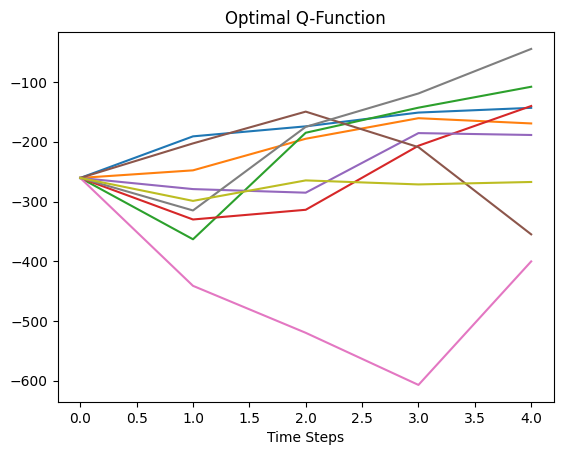

202.45369934250144


In [ ]:
# Q function
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1)) #create datafunction to store optimal values of Q function
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1]) #Q function at terminal value


for t in range(T-1, -1, -1):
#calculate optimal action value function
    C_mat = function_C_vec(t,data_mat_t,reg_param)
    D_vec = function_D_vec(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec) #omega in eq is caluated by multiplying inv of C vec by D vec

    Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega) #multiply state variable and omega

Q = Q.astype('float')

# plot 10 paths for optimal Q function
plt.plot(Q.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Q-Function')
plt.show()
print(np.mean(-Q.T.iloc[:,2]))

In [ ]:
# The Black-Scholes prices by codifying its eq
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [ ]:

np.random.seed(42) # Fix random seed

# disturbed optimal actions to be computed
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# also make portfolios and rewards
# portfolio value
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1]-K

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# reward function
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):


    # Compute the optimal policy(which was calculated in DP approach), and write the result to a_op
    a_op.loc[:, t] = a.loc[:, t]
    # Now disturb these values by a random noise
    a_op.loc[:, t] *= np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])
    # Compute portfolio values corresponding to observed actions
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])

    # Compute rewards corrresponding to observed actions
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])

R_op.loc[:,t]

,0
1,24.184843
2,-33.884486
3,-51.939774
4,1.869932
5,-81.899922
6,130.365239
7,-56.130663
8,-57.318796
9,-18.42485
10,-0.7548


In [ ]:
#Generate random actions for off-policy data
np.random.seed(42)
idx_row = np.random.randint(low=0, high=R_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=R_op.shape[1], size=10)
R_op.loc[idx_row, idx_col].values.flatten()

array([-9.60559398622372, -40.05711892423923, -23.846953643415205,
       -40.05711892423923, -40.05711892423923, -65.24667706167074,
       -23.846953643415205, -23.846953643415205, -23.846953643415205,
       -40.05711892423923, -23.512683523107416, -40.05711892423923,
       -86.32856292022298, -40.05711892423923, -40.05711892423923,
       -118.16550896247878, -86.32856292022298, -86.32856292022298,
       -86.32856292022298, -40.05711892423923, -36.04417172352455,
       -40.05711892423923, -192.87379685904293, -40.05711892423923,
       -40.05711892423923, 79.30553855296509, -192.87379685904293,
       -192.87379685904293, -192.87379685904293, -40.05711892423923,
       -15.57404293033107, -40.05711892423923, 63.954741800153144,
       -40.05711892423923, -40.05711892423923, 19.60403544127031,
       63.954741800153144, 63.954741800153144, 63.954741800153144,
       -40.05711892423923, -45.63677544963764, -40.05711892423923,
       -106.52660710331962, -40.05711892423923, -40.057

In [ ]:
#Generate random actions for off-policy data
np.random.seed(42)
idx_row = np.random.randint(low=0, high=Pi_op.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=Pi_op.shape[1], size=10)
Pi_op.loc[idx_row, idx_col].values.flatten()

array([142.38113152231932, 162.83561384616772, 146.39970328828352,
       162.83561384616772, 162.83561384616772, 199.89274595358626,
       146.39970328828352, 146.39970328828352, 146.39970328828352,
       162.83561384616772, 38.09684890205536, 41.71278941300759,
       107.12095059372372, 41.71278941300759, 41.71278941300759,
       214.4834617514452, 107.12095059372372, 107.12095059372372,
       107.12095059372372, 41.71278941300759, 131.70440236038627,
       124.79975116609396, 305.00821886248923, 124.79975116609396,
       124.79975116609396, 210.1103532790396, 305.00821886248923,
       305.00821886248923, 305.00821886248923, 124.79975116609396,
       246.9476971956528, 263.8792193485687, 160.6338209668889,
       263.8792193485687, 263.8792193485687, 128.931652585221,
       160.6338209668889, 160.6338209668889, 160.6338209668889,
       263.8792193485687, 91.6760924629077, 73.94811031153074,
       179.60149681749652, 73.94811031153074, 73.94811031153074,
       249.0464279

In [ ]:
# Override on-policy data with off-policy data
a = a_op.copy()      # distrubed actions
Pi = Pi_op.copy()    # disturbed portfolio values
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

In [ ]:
# make matrix A_t
num_MC = a.shape[0] # number of simulated paths
num_TS = a.shape[1] # number of time steps
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2)) #stacking up the to make a 3x1 matrix

print(A_stack.shape)

(3, 10000, 5)


In [ ]:
#Swaps the first and third axes of data_mat_t.
#This operation rearranges the dimensions to align with the subsequent calculations.
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)

print(data_mat_swap_idx.shape)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)
print('A_2',A_2.shape)
print('data_mat_swap_idx',data_mat_swap_idx.shape)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

print('Psi_mat',Psi_mat.shape)

(12, 10000, 5)
A_2 (3, 1, 10000, 5)
data_mat_swap_idx (1, 12, 10000, 5)
Psi_mat (36, 10000, 5)


In [ ]:
# make matrix S_t

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S1_t_mat = np.multiply(Psi_1_aux, Psi_2_aux)
S_t_mat = np.sum(S1_t_mat, axis=2)
print(S1_t_mat.shape)
print(S_t_mat.shape)

(36, 1, 10000, 5) (1, 36, 10000, 5)
(36, 36, 10000, 5)
(36, 36, 5)


In [ ]:
# clean up some space
del Psi_1_aux, Psi_2_aux, data_mat_swap_idx, A_2

In [ ]:
#calculate st and mt matrix
def function_S_vec(t, S_t_mat, reg_param):
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)

    return S_mat_reg

def function_M_vec(t,
                   Q_star,
                   R,
                   Psi_mat_t,
                   gamma=gamma):

    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])

    return M_t

In [ ]:
np.random.seed(42)
S_mat_reg = function_S_vec(T-1, S_t_mat, reg_param)
idx_row = np.random.randint(low=0, high=S_mat_reg.shape[0], size=10)

np.random.seed(42)
idx_col = np.random.randint(low=0, high=S_mat_reg.shape[1], size=10)

S_mat_reg[idx_row, idx_col].flatten().astype(float)

array([5.72778224e+01, 6.06029827e+01, 8.21311813e+01, 3.21748772e+02,
       1.28106674e+03, 1.20082863e+03, 5.78789131e+01, 5.78789131e+01,
       3.14801014e+02, 1.22763251e+00])

In [ ]:

Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

M_t = function_M_vec(T-1, Q_star, R, Psi_mat[:,:,T-1], gamma)
M_t = M_t.astype(float)

M_t

array([-2.12648231e+01,  1.14936418e+02, -1.91866074e+02, -1.36582770e+02,
        3.82040246e+02, -5.27815181e+01, -1.84372660e+03,  1.32608393e+03,
       -1.73853238e+03, -1.73858611e+04, -5.82282313e+03, -4.68148404e+03,
       -1.17821517e+05, -9.84022100e+04, -4.62344629e+04, -3.37289709e+05,
       -3.41543546e+05, -1.74895547e+05, -6.12110237e+05, -6.16097566e+05,
       -3.11207144e+05, -8.06078721e+05, -8.09390583e+05, -4.08879473e+05,
       -4.02914696e+05, -4.04454312e+05, -2.07929339e+05, -1.29148603e+05,
       -1.27973431e+05, -7.32534947e+04, -2.83108183e+04, -1.63323408e+04,
       -1.39517244e+04, -2.92353399e+03,  1.15804862e+03, -1.66294676e+03])

In [ ]:
# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

hyper_param =  1e-1

# The backward loop
for t in range(T-1, -1, -1):

    # calculate vector W_t
    S_mat_reg = function_S_vec(t, S_t_mat, reg_param)
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    S_mat_reg_inv= np.linalg.inv(S_mat_reg.astype(float))
    W_t = np.dot(S_mat_reg_inv,M_t)

    # reshape to a matrix W_mat
    W_mat = W_t.reshape((3, num_basis), order='F')

    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T

    # compute matrix U_mat
    U_mat = np.dot(W_mat, Phi_mat)

    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t)

    phi = np.dot(np.linalg.inv(A_mat), B_vec)

    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t]

    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2

    # update dataframes
    Q_star.loc[:,t] = max_Q_star[:,t]

    Psi_t = Psi_mat[:,:,t].T
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)

    # trim outliers for Q_RL
    up_percentile_Q_RL =  95
    low_percentile_Q_RL = 5

    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])

    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
print(Q_star.loc[:,:])

<ipython-input-31-513d61b53cd8>:67: RuntimeWarning: invalid value encountered in less
  flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
<ipython-input-31-513d61b53cd8>:68: RuntimeWarning: invalid value encountered in greater
  flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL


         0    1    2            3            4
1      NaN  NaN  NaN  -290.894807   -448.94044
2      NaN  NaN  NaN  -301.617256  -351.461244
3      NaN  NaN  NaN  -179.126447  -118.481624
4      NaN  NaN  NaN   -63.994136   -23.634685
5      NaN  NaN  NaN  -117.372046   -42.333583
...    ...  ...  ...          ...          ...
9996   NaN  NaN  NaN  -180.773136  -131.834077
9997   NaN  NaN  NaN  -155.392475  -106.551336
9998   NaN  NaN  NaN -1139.894176 -1782.447404
9999   NaN  NaN  NaN  -125.042684  -149.712679
10000  NaN  NaN  NaN  -373.702328   -375.32706

[10000 rows x 5 columns]


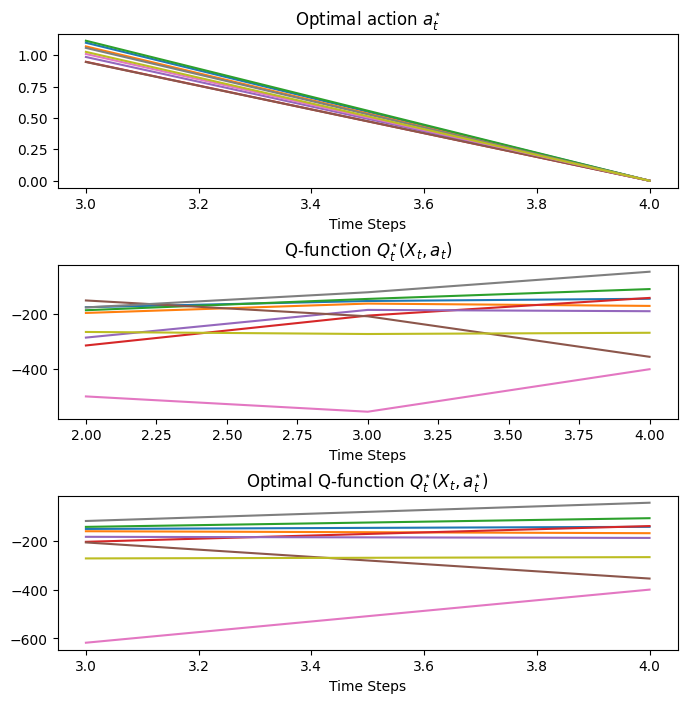

In [ ]:
# plot both simulations
f, axarr = plt.subplots(3, 1)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0].plot(a_star.T.iloc[:, idx_plot])
axarr[0].set_xlabel('Time Steps')
axarr[0].set_title(r'Optimal action $a_t^{\star}$')

axarr[1].plot(Q_RL.T.iloc[:, idx_plot])
axarr[1].set_xlabel('Time Steps')
axarr[1].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[2].plot(Q_star.T.iloc[:, idx_plot])
axarr[2].set_xlabel('Time Steps')
axarr[2].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$')

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600)
plt.show()

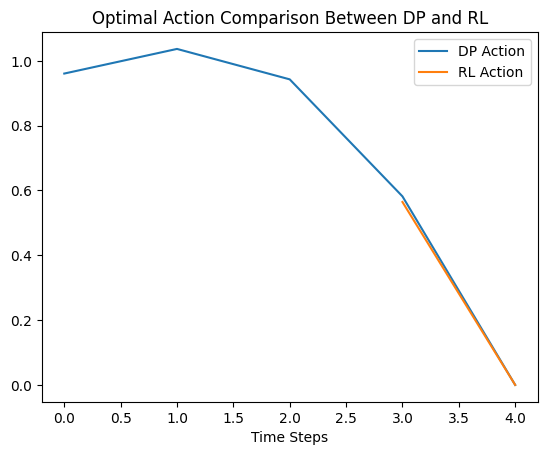

In [ ]:
# plot a and a_star
num_path =  120

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()

In [ ]:
# QLBS option price
C_QLBS = - Q_star.iloc[:,1] # Q_RL #
C_QLBS2 = - Q_RL.iloc[:,1]
C_QLBS_1Q= -Q.iloc[:,0]
C_QLBS_2Q= -Q.iloc[:,1]
C_QLBS_3Q= -Q.iloc[:,2]
C_QLBS_4Q= -Q.iloc[:,3]
optimal_hedge_1Q= a.loc[:,0]
optimal_hedge_2Q= a.loc[:,1]
optimal_hedge_3Q= a.loc[:,2]
optimal_hedge_4Q= a.loc[:,3]
print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-25s' % ('\nNoise(eta) :'), (eta))
print('%-25s' % ('\nRegulatory parameter :'), (reg_param))
print('%-25s' % ('\nTerminal Payoff :'), (terminal_payoff(S0,K)))
print('%-25s' % ('\n         1st Quarter       '))
print('%-26s %.4f' % ('\nOptimal Hedge :',np.mean(optimal_hedge_1Q)))
print('%-26s %.4f' % ('\nQLBS price 1Q :',np.mean(C_QLBS_1Q)))
print('%-25s' % ('\n         2nd Quarter       '))
print('%-26s %.4f' % ('\nOptimal Hedge :',np.mean(optimal_hedge_2Q)))
print('%-26s %.4f' % ('\nQLBS price 2Q :',np.mean(C_QLBS_2Q)))
print('%-25s' % ('\n         3rd Quarter       '))
print('%-26s %.4f' % ('\nOptimal Hedge :',np.mean(optimal_hedge_3Q)))
print('%-26s %.4f' % ('\nQLBS price 3Q :',np.mean(C_QLBS_3Q)))
print('%-25s' % ('\n         4th Quarter       '))
print('%-26s %.4f' % ('\nOptimal Hedge :',np.mean(optimal_hedge_4Q)))
print('%-26s %.4f' % ('\nQLBS price 4Q :',np.mean(C_QLBS_4Q)))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_call(0)))
print('\n')


---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      234.23
Drift of Stock:           0.056
Volatility of Stock:      0.71
Risk-free Rate:           0.098
Risk aversion parameter : 0.001
Strike:                   63.65
Maturity:                 1

Noise(eta) :             0.05

Regulatory parameter :   0.001

Terminal Payoff :        170.57999999999998

         1st Quarter       

Optimal Hedge :           0.9752

QLBS price 1Q :           260.5544

         2nd Quarter       

Optimal Hedge :           0.9524

QLBS price 2Q :           264.3156

         3rd Quarter       

Optimal Hedge :           0.9353

QLBS price 3Q :           258.8502

         4th Quarter       

Optimal Hedge :           0.9413

QLBS price 4Q :           245.6432

Black-Sholes Put Price:   177.2386




d= np.log(S0/K)+(r+(sigma**2)/2)*T
d1=d/(sigma*np.sqrt(T))
print(d1)